Predicted versus true concentrations

natural water (NW) samples are plotted as circles (○), municipal wastewater (WW) as squares (□)

single OMPs are shown in solid symbols, while mixture samples (two or three OMPs) use open symbols



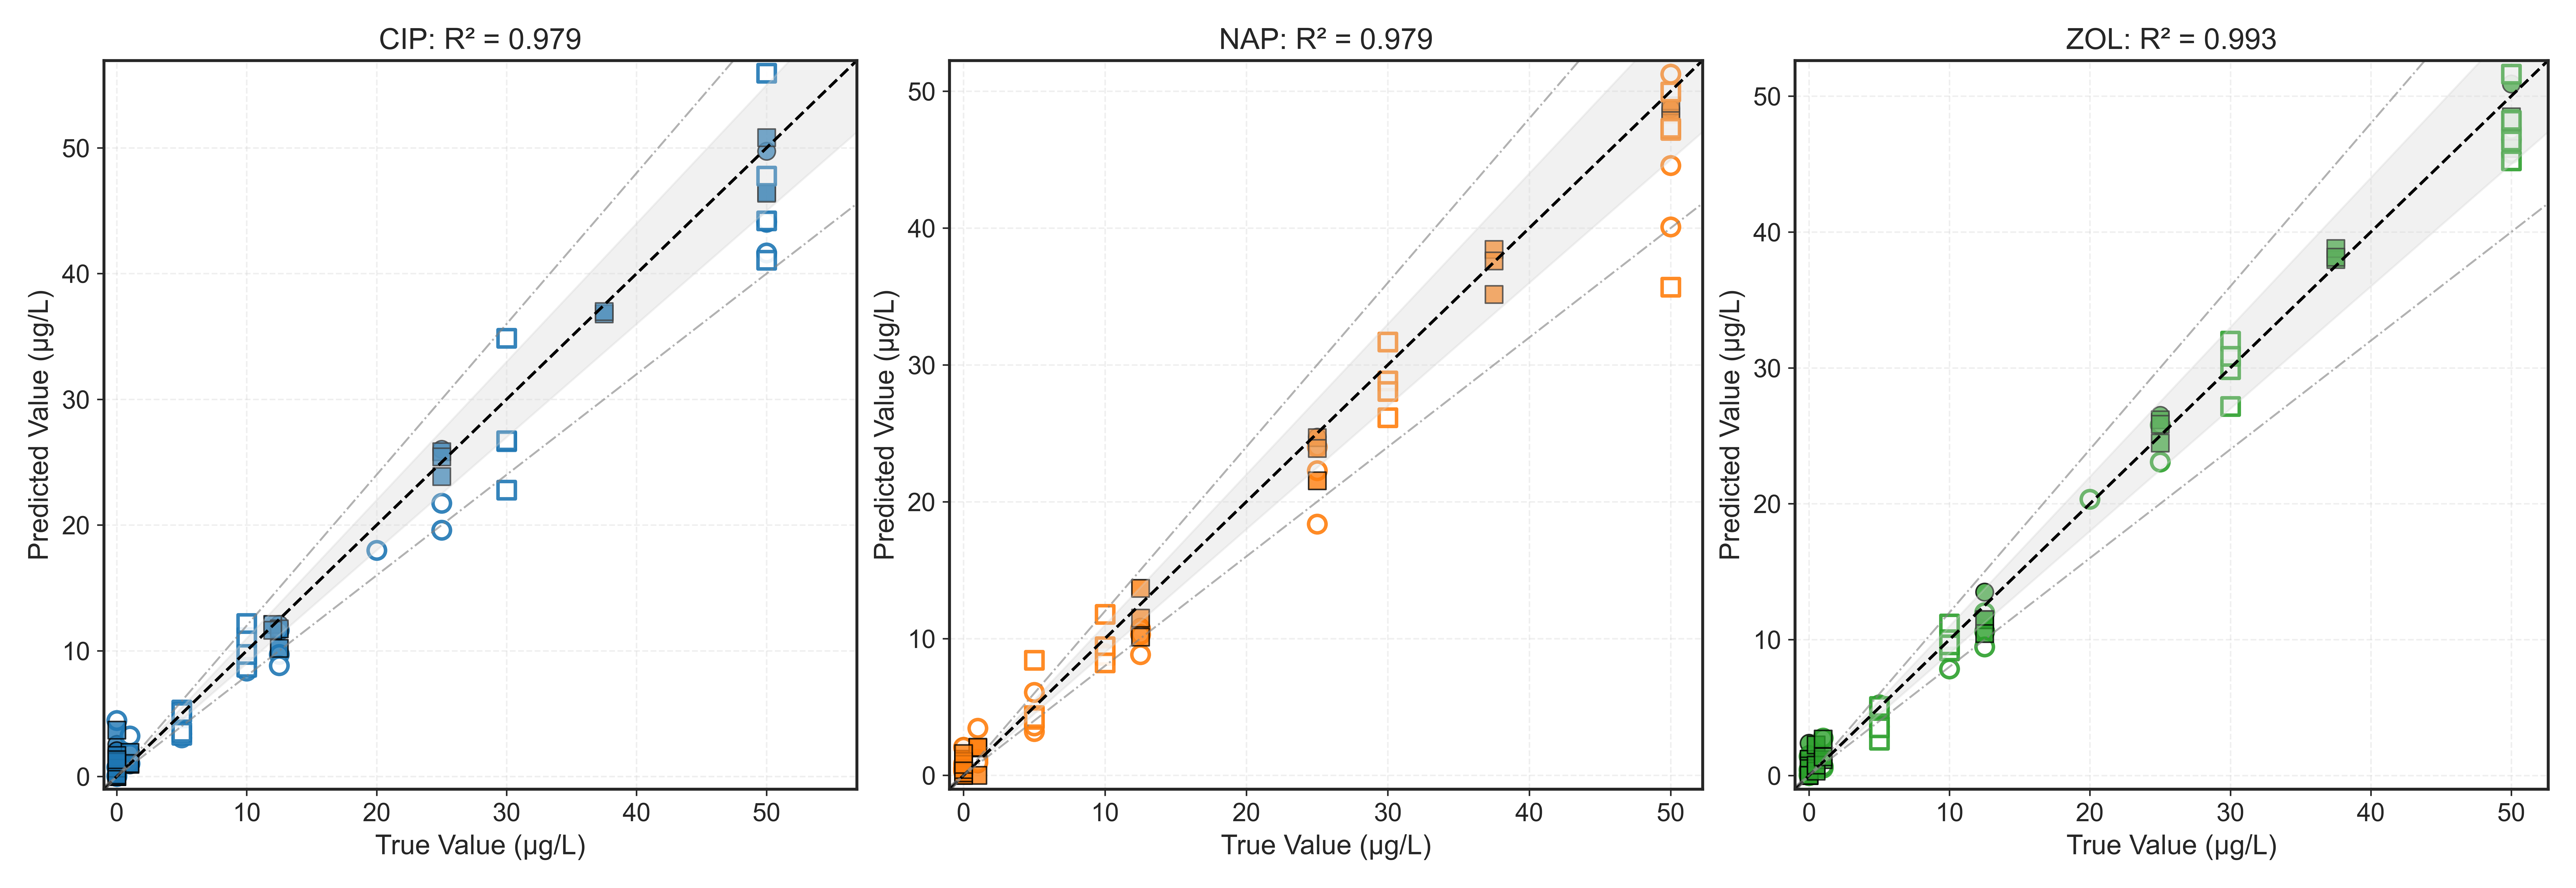

Within-relative-error rates

--------------------------------------------------------------------------------
Target  > 2 μg/L @ ±10%> 2 μg/L @ ±15%> 2 μg/L @ ±20%> 5 μg/L @ ±10%> 5 μg/L @ ±15%> 5 μg/L @ ±20%> 10 μg/L @ ±10%> 10 μg/L @ ±15%> 10 μg/L @ ±20%
--------------------------------------------------------------------------------
CIP              44.4%         66.7%         77.8%         45.9%         73.0%         86.5%         50.0%         75.0%         87.5%
NAP              46.7%         66.7%         82.2%         56.8%         78.4%         91.9%         62.5%         81.2%         90.6%
ZOL              77.8%         80.0%         86.7%         86.5%         89.2%         94.6%         90.6%         90.6%         96.9%
--------------------------------------------------------------------------------
Bland–Altman (mean–difference) plots



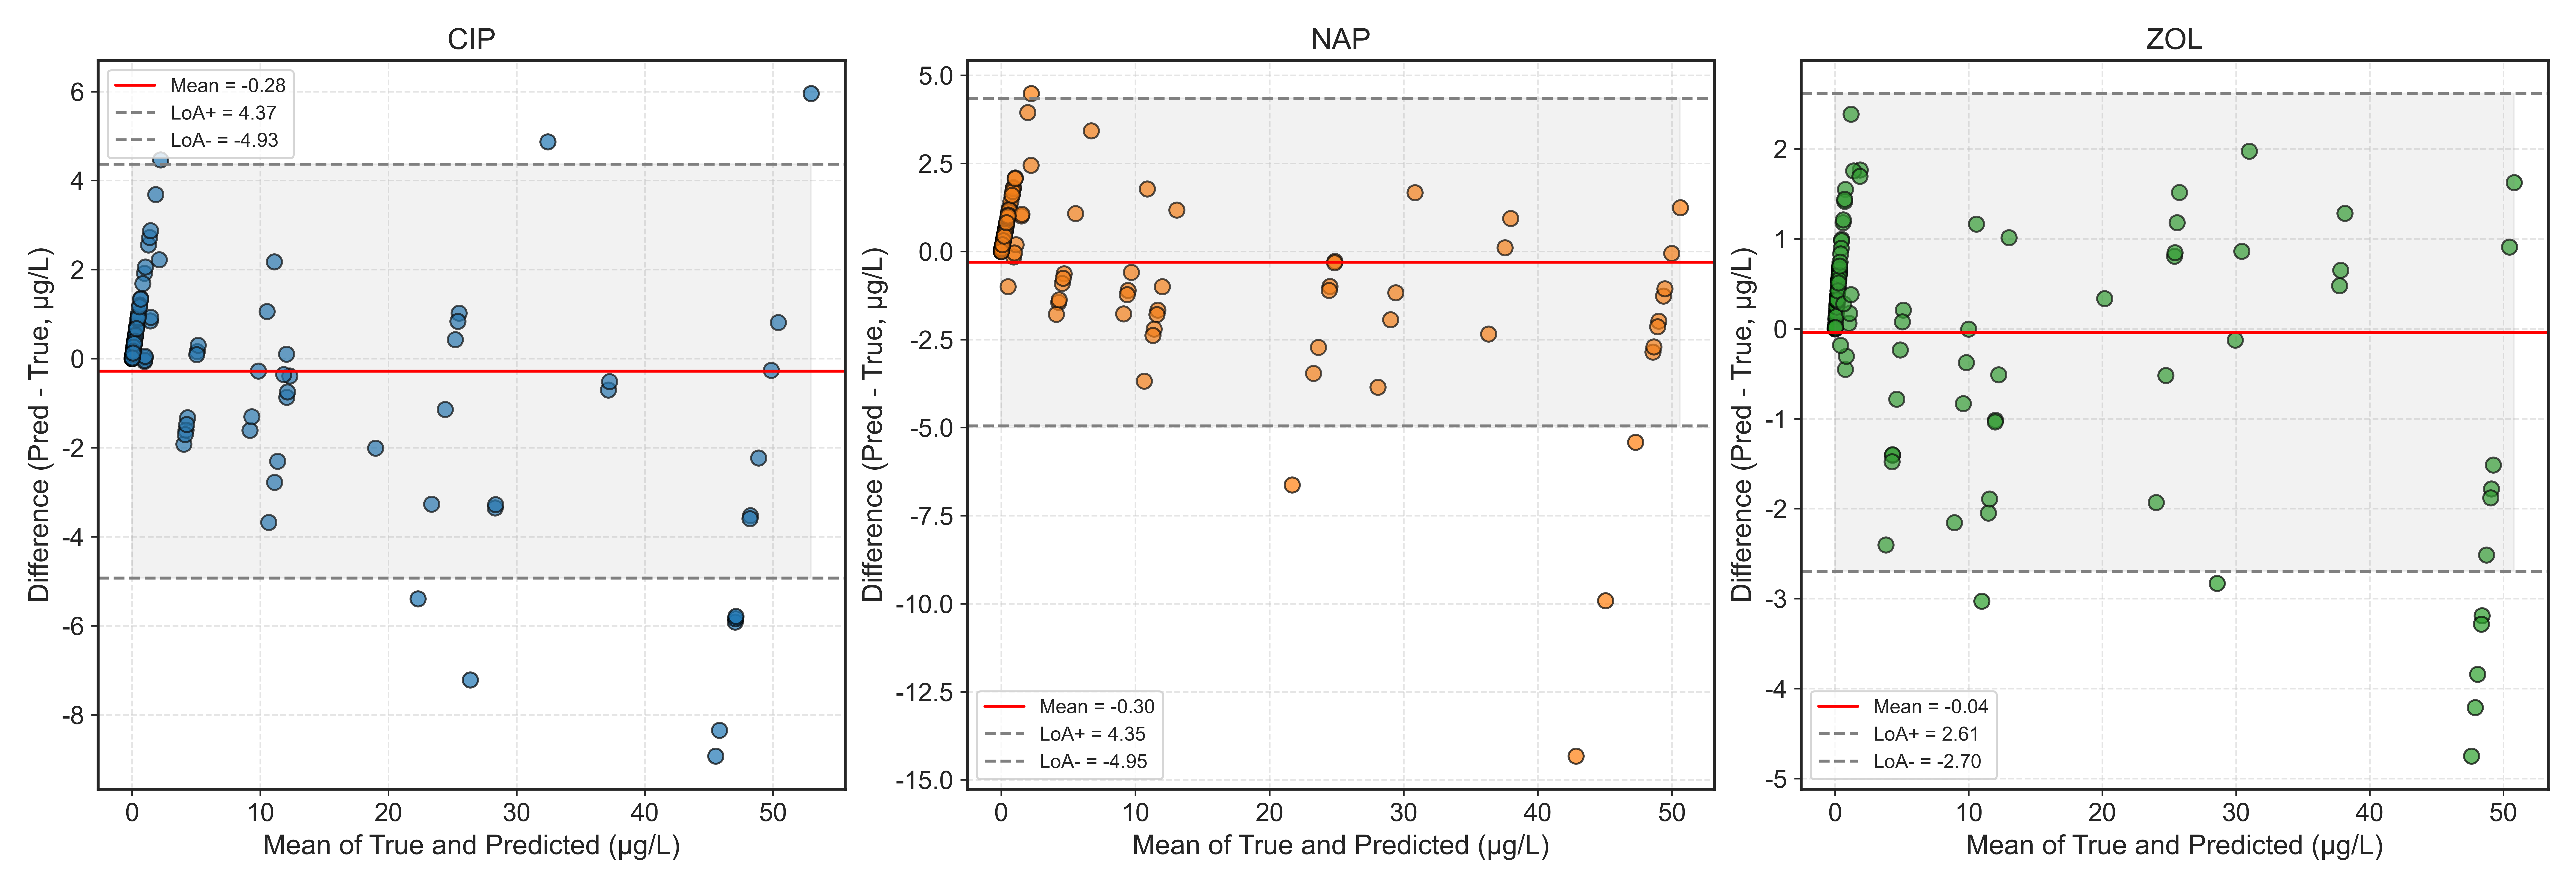

Model performance stability



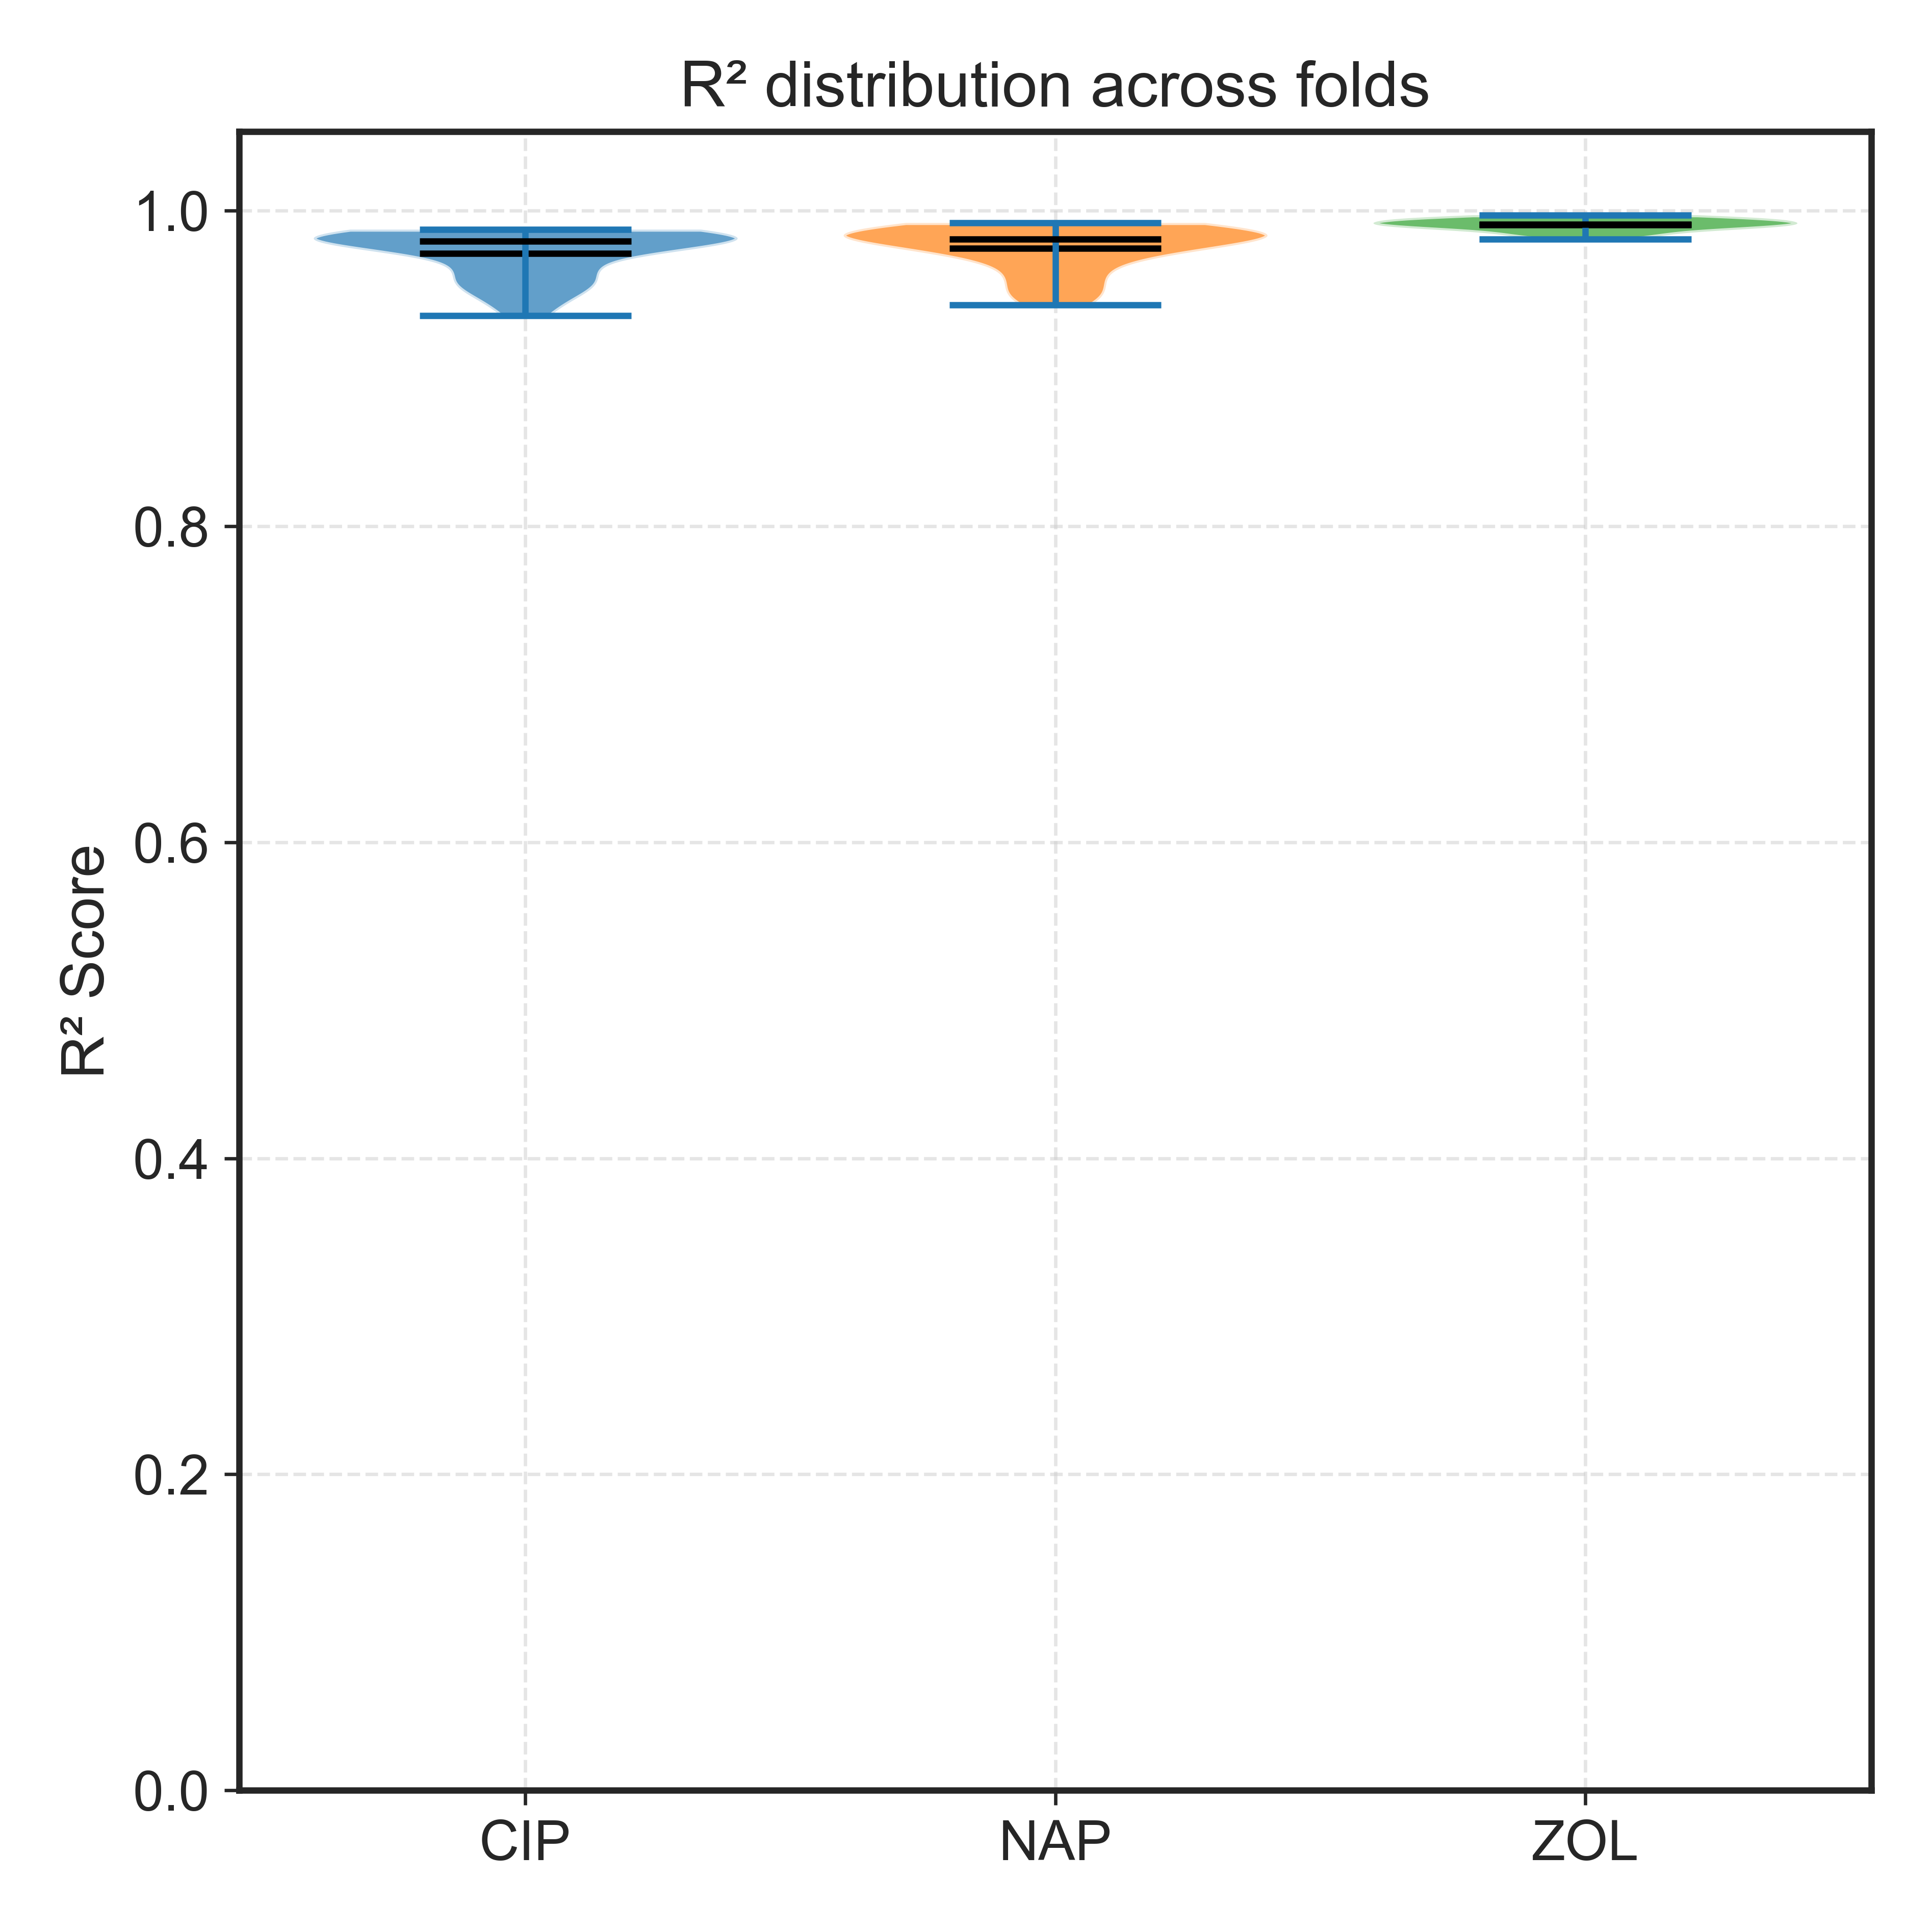

Summary combined prediction plot



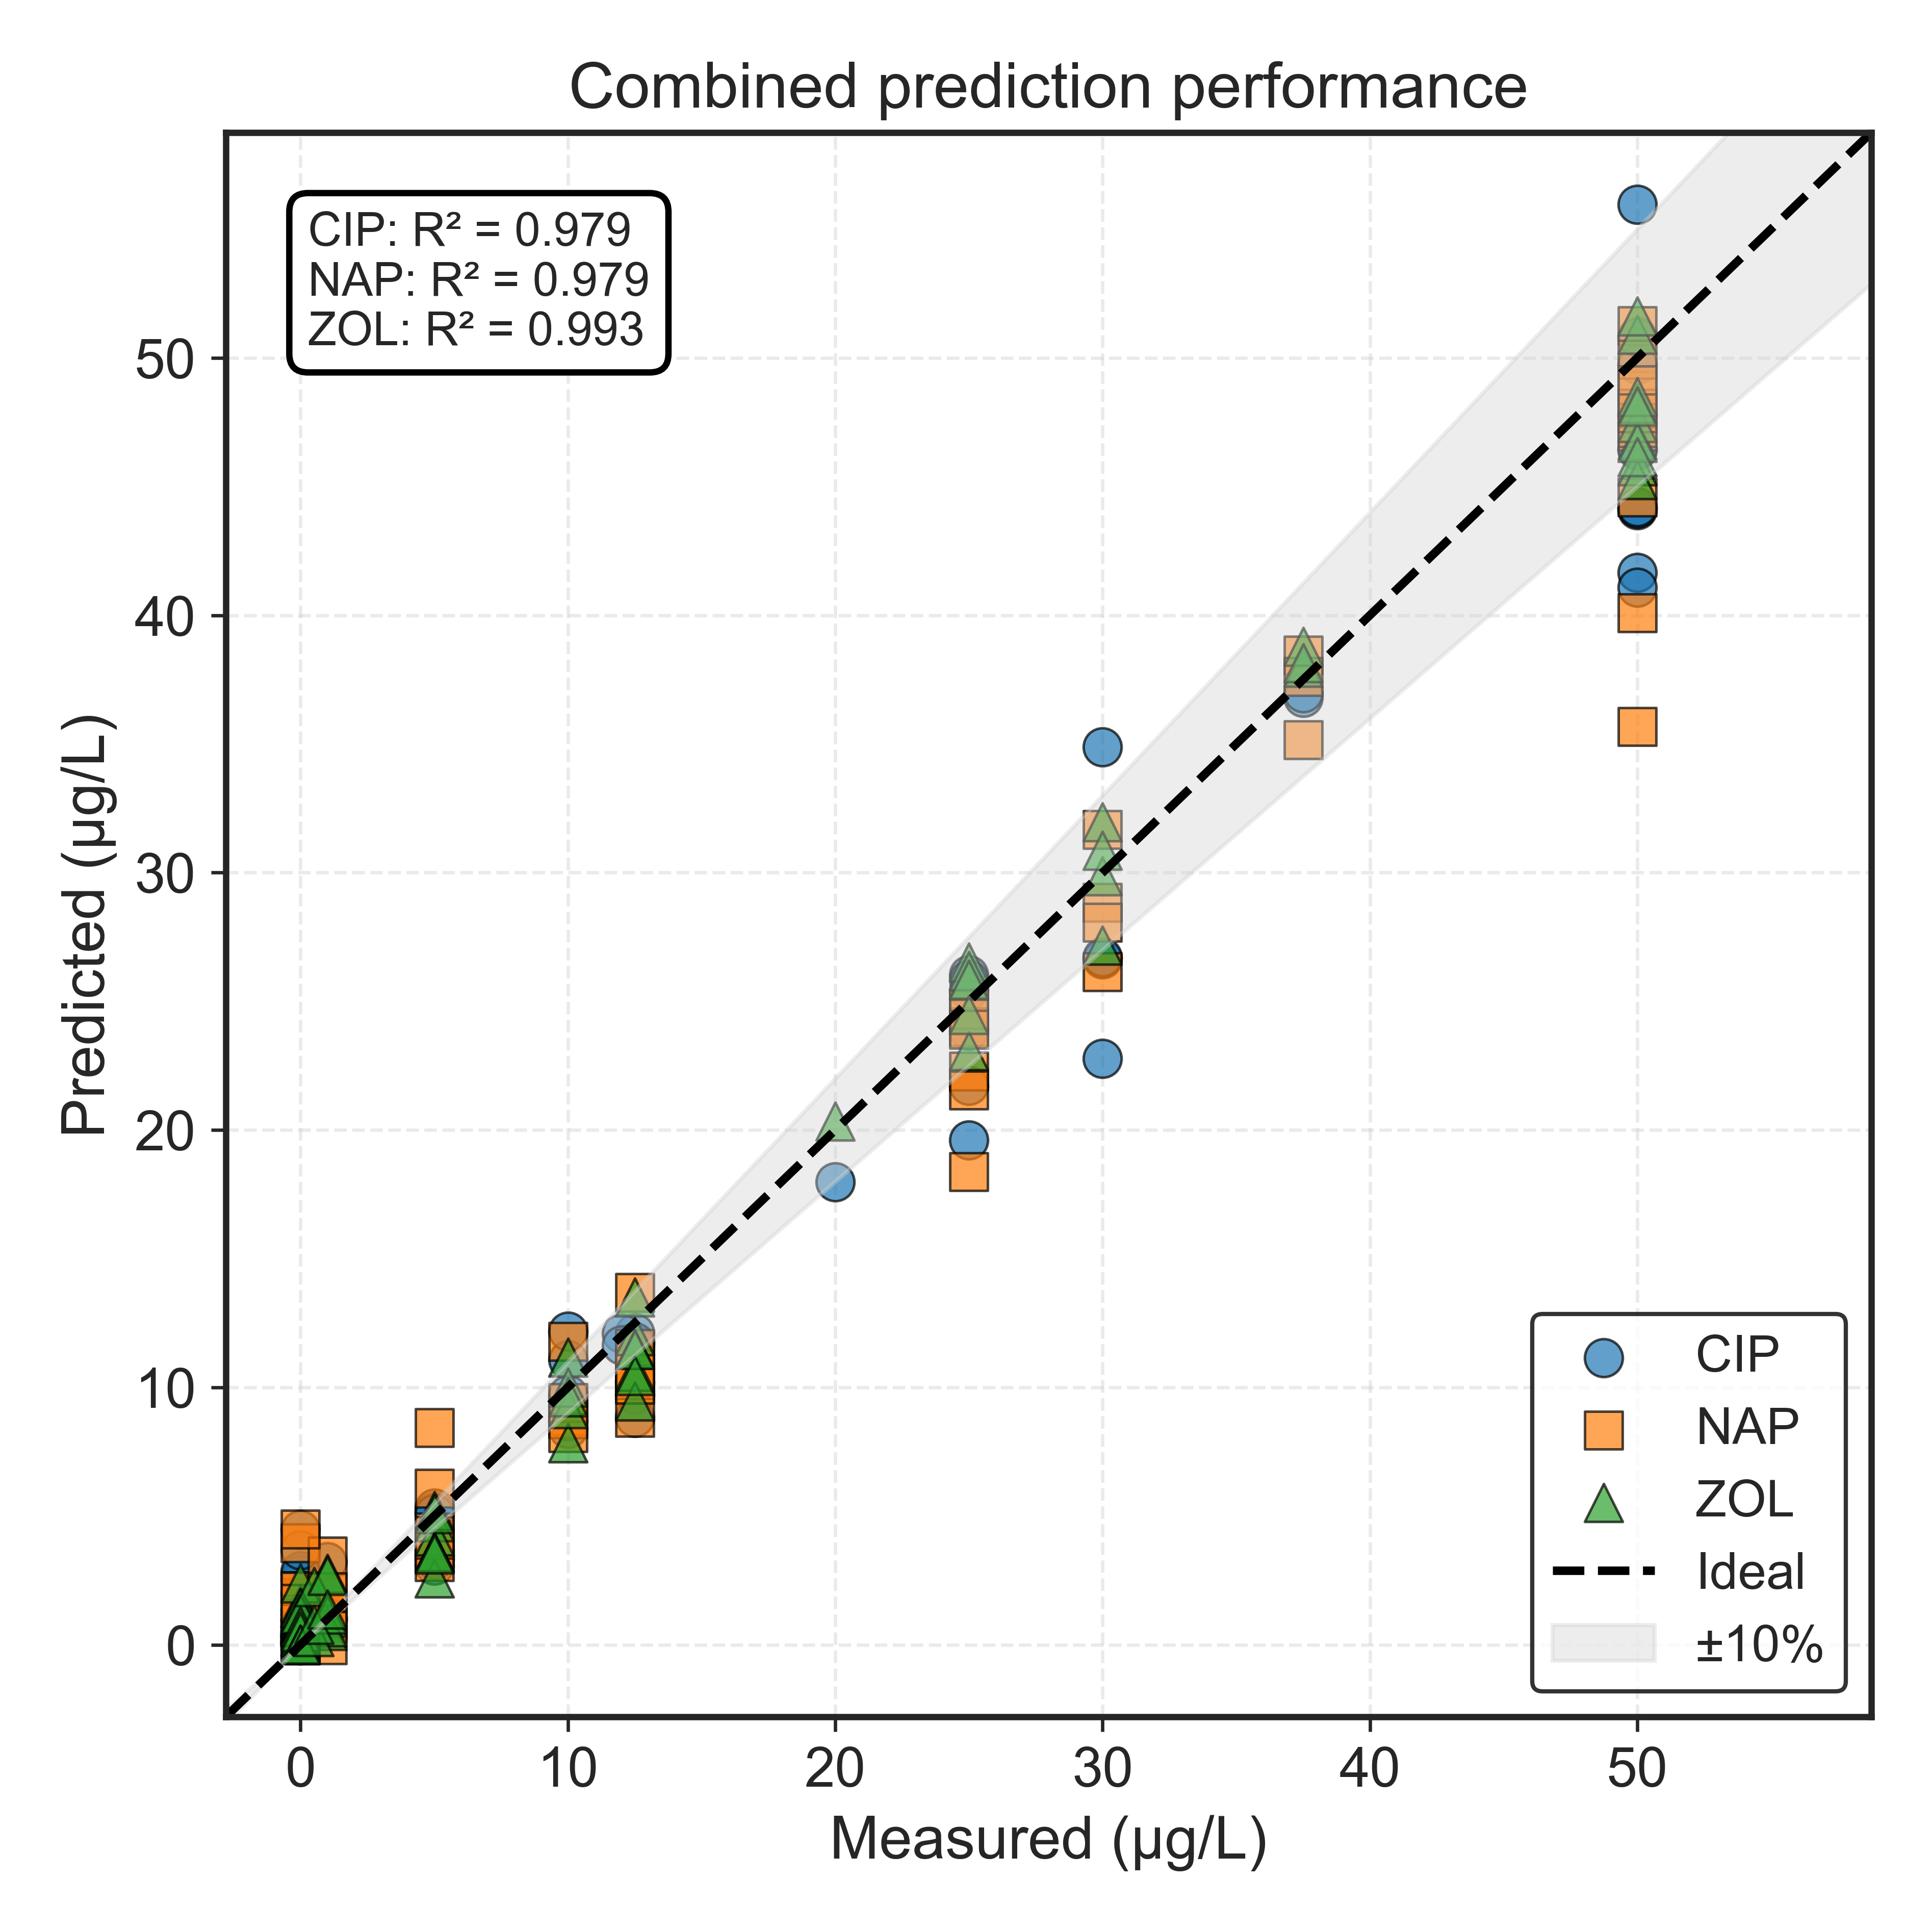


Limits of detection (LOD) and quantification (LOQ) 

Dataset                   Compound   LOD (μg/L)   LOQ (μg/L)  Blank n
--------------------------------------------------------------------------------
Full Dataset              CIP              3.17         9.62       54
Full Dataset              NAP              2.90         8.80       54
Full Dataset              ZOL              1.52         4.59       51
Natural Water (NW)        CIP              3.86        11.70       18
Natural Water (NW)        NAP              3.00         9.08       18
Natural Water (NW)        ZOL              2.12         6.43       18
Wastewater (WW)           CIP              2.61         7.92       36
Wastewater (WW)           NAP              2.60         7.87       36
Wastewater (WW)           ZOL              1.07         3.23       33
--------------------------------------------------------------------------------


In [15]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.lines import Line2D

# Set global seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Configure plotting style
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'Arial',
    'axes.linewidth': 1.5,
    'axes.labelsize': 14,
    'axes.titlesize': 15,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 12,
    'figure.dpi': 600,
    'savefig.dpi': 600,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.2,
})
sns.set_style("ticks")

# 1. Load EEM data (replace NaN with 0)
def load_eem(filepath):
    try:
        df = pd.read_csv(filepath, index_col=0)
        eem = df.values.astype(np.float32)
        eem = np.nan_to_num(eem, nan=0.0)
        return eem
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None

# 2. Construct dataset from metadata and EEM files
def load_dataset(metadata_path, data_dir):
    meta = pd.read_csv(metadata_path, sep=";")
    X, y = [], []
    for _, row in meta.iterrows():
        sid = row["sample_identifier"]
        csv_path = os.path.join(data_dir, f"{sid}.csv")
        eem = load_eem(csv_path)
        if eem is None:
            continue
        X.append(eem)
        y.append([row["conc_cip"], row["conc_nap"], row["conc_zol"]])
    return np.array(X), np.array(y)

# Load natural water and wastewater datasets
X_nat, y_nat = load_dataset("Natural_water/metadata_natural_water.csv", "Natural_water")
X_wast, y_wast = load_dataset("Wastewater/metadata_wastewater.csv", "Wastewater")

# Create source labels: 0 = natural water (NW), 1 = wastewater (WW)
labels_nat = np.zeros(len(X_nat), dtype=int)
labels_wast = np.ones(len(X_wast), dtype=int)

# Merge datasets
X_raw = np.concatenate([X_nat, X_wast], axis=0)
y_raw = np.concatenate([y_nat, y_wast], axis=0)
source_labels = np.concatenate([labels_nat, labels_wast], axis=0)

n_samples, n_targets = X_raw.shape[0], y_raw.shape[1]

# ================================================================================
# Generate sample type labels (0=single OMPs, 1=mixture, 2=blank)
# ================================================================================
sample_type = np.zeros(n_samples, dtype=int)  # default to single
for i in range(n_samples):
    concs = y_raw[i]
    if np.all(concs == 0):
        sample_type[i] = 2  # blank (all zeros)
    elif np.sum(concs > 0) == 1:
        sample_type[i] = 0  # single OMPs (exactly one >0)
    else:
        sample_type[i] = 1  # mixture (two or three >0)

n_single = np.sum(sample_type == 0)
n_mixture = np.sum(sample_type == 1)
n_blank = np.sum(sample_type == 2)


# 3. Define CNN architecture for EEM spectral analysis
class EEMCNN(nn.Module):
    def __init__(self, num_targets=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.GELU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.AdaptiveAvgPool2d((8, 8)),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_targets)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# 4. Compute within-relative-error rates at concentration thresholds
def compute_within_error_rates(y_true, y_pred, thresholds_conc=[2, 5, 10], error_levels=[0.1, 0.15, 0.2]):
    results = {}
    targets = ["CIP", "NAP", "ZOL"]
    for i, name in enumerate(targets):
        results[name] = {}
        y_t = y_true[:, i]
        y_p = y_pred[:, i]
        for th in thresholds_conc:
            mask = y_t > th
            n_valid = np.sum(mask)
            if n_valid == 0:
                for err in error_levels:
                    results[name][f"> {th} μg/L @ ±{int(err*100)}%"] = 0.0
                continue
            rel_err = np.abs((y_t[mask] - y_p[mask]) / y_t[mask])
            for err in error_levels:
                within = np.sum(rel_err <= err)
                rate = within / n_valid
                results[name][f"> {th} μg/L @ ±{int(err*100)}%"] = rate
    return results

# 5. Calculate limits of detection (LOD) using blank samples
def calculate_lod(y_true, y_pred, compound_name):
    n_blank = len(y_true)

    if n_blank < 7: 
        return np.nan, np.nan, n_blank

    sigma_blank = np.std(y_pred, ddof=1) 
        
       
    S = 1.0
    LOD = (3.3 * sigma_blank) / S
    LOQ = (10 * sigma_blank) / S
    
    return LOD, LOQ, n_blank

# 6. Perform repeated stratified k-fold cross-validation
n_splits = 5
n_repeats = 5
rkf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_folds = n_splits * n_repeats
oof_predictions_raw = np.full((n_folds, n_samples, n_targets), np.nan)
fold_r2_scores = []

for fold, (train_idx, test_idx) in enumerate(rkf.split(X_raw, source_labels)):
    X_train, X_test = X_raw[train_idx], X_raw[test_idx]
    y_train, y_test = y_raw[train_idx], y_raw[test_idx]


    X_min, X_max = X_train.min(), X_train.max()
    X_train_norm = (X_train - X_min) / (X_max - X_min + 1e-8)
    X_test_norm = (X_test - X_min) / (X_max - X_min + 1e-8)


    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)


    X_train_t = torch.tensor(X_train_norm[:, None, :, :], dtype=torch.float32)
    X_test_t = torch.tensor(X_test_norm[:, None, :, :], dtype=torch.float32)
    y_train_t = torch.tensor(y_train_scaled, dtype=torch.float32)
    y_test_t = torch.tensor(y_test_scaled, dtype=torch.float32)
    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=8, shuffle=True)


    model = EEMCNN(num_targets=n_targets).to(device)
    X_test_t = X_test_t.to(device)
    y_test_t = y_test_t.to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=120)
    
    model.train()
    for epoch in range(120):
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        scheduler.step()

  
    model.eval()
    with torch.no_grad():
        y_pred_scaled = model(X_test_t).cpu().numpy()
        y_pred_orig = scaler_y.inverse_transform(y_pred_scaled)
        y_pred_orig = np.maximum(y_pred_orig, 0)
    
    r2_fold = [r2_score(y_test[:, i], y_pred_orig[:, i]) for i in range(n_targets)]
    fold_r2_scores.append(r2_fold)
    oof_predictions_raw[fold, test_idx, :] = y_pred_orig

oof_predictions = np.full((n_samples, n_targets), np.nan)
for i in range(n_samples):
    preds = oof_predictions_raw[:, i, :]
    valid = ~np.isnan(preds[:, 0])
    oof_predictions[i] = np.mean(preds[valid], axis=0)
oof_predictions = np.maximum(oof_predictions, 0)

overall_r2 = [r2_score(y_raw[:, i], oof_predictions[:, i]) for i in range(n_targets)]
mean_overall_r2 = np.mean(overall_r2)
fold_r2_scores = np.array(fold_r2_scores)
mean_fold_r2 = np.mean(fold_r2_scores, axis=0)
std_fold_r2 = np.std(fold_r2_scores, axis=0)

non_blank_mask = (sample_type != 2)
y_non_blank = y_raw[non_blank_mask]
oof_non_blank = oof_predictions[non_blank_mask]
source_non_blank = source_labels[non_blank_mask]
sample_type_non_blank = sample_type[non_blank_mask]

# 7. Generate Prediction vs. True plots with 4-way distinction (NW/WW × Single/Mixture)
targets = ["CIP", "NAP", "ZOL"]
colors = ['tab:blue', 'tab:orange', 'tab:green']

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
print("Predicted versus true concentrations\n")
print("natural water (NW) samples are plotted as circles (○), municipal wastewater (WW) as squares (□)\n")
print("single OMPs are shown in solid symbols, while mixture samples (two or three OMPs) use open symbols\n")


for i, (name, color) in enumerate(zip(targets, colors)):
    y_t = y_non_blank[:, i]
    y_p = oof_non_blank[:, i]
    ax = axes[i]
    
    # Category 1: Natural water + Single OMPs (solid circle with black edge)
    mask = (source_non_blank == 0) & (sample_type_non_blank == 0)
    if np.any(mask):
        ax.scatter(y_t[mask], y_p[mask],
                   marker='o',
                   facecolors=color,
                   edgecolors='k',
                   s=80,
                   linewidths=0.8,
                   alpha=0.8,
                   label='Natural water + Single' if i == 0 else "")
    
    # Category 2: Natural water + Mixture (hollow circle with colored edge)
    mask = (source_non_blank == 0) & (sample_type_non_blank == 1)
    if np.any(mask):
        ax.scatter(y_t[mask], y_p[mask],
                   marker='o',
                   facecolors='white',
                   edgecolors=color,
                   s=80,
                   linewidths=1.8,
                   alpha=0.9,
                   label='Natural water + Mixture' if i == 0 else "")
    
    # Category 3: Wastewater + Single OMPs (solid square with black edge)
    mask = (source_non_blank == 1) & (sample_type_non_blank == 0)
    if np.any(mask):
        ax.scatter(y_t[mask], y_p[mask],
                   marker='s',
                   facecolors=color,
                   edgecolors='k',
                   s=80,
                   linewidths=0.8,
                   alpha=0.8,
                   label='Wastewater + Single' if i == 0 else "")
    
    # Category 4: Wastewater + Mixture (hollow square with colored edge)
    mask = (source_non_blank == 1) & (sample_type_non_blank == 1)
    if np.any(mask):
        ax.scatter(y_t[mask], y_p[mask],
                   marker='s',
                   facecolors='white',
                   edgecolors=color,
                   s=80,
                   linewidths=1.8,
                   alpha=0.9,
                   label='Wastewater + Mixture' if i == 0 else "")
    
    
    lims = [np.min([y_t.min(), y_p.min()]) - 1, np.max([y_t.max(), y_p.max()]) + 1]
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.plot(lims, lims, 'k--', linewidth=1.5, label='Ideal (y=x)' if i == 0 else "")
    x_line = np.linspace(lims[0], lims[1], 200)
    ax.fill_between(x_line, 0.9 * x_line, 1.1 * x_line, color='lightgray', alpha=0.3, label='±10%' if i == 0 else "")
    ax.plot(x_line, 1.2 * x_line, 'gray', linestyle='-.', linewidth=1.0, alpha=0.6)
    ax.plot(x_line, 0.8 * x_line, 'gray', linestyle='-.', linewidth=1.0, alpha=0.6)
    
    ax.set_xlabel('True Value (μg/L)')
    ax.set_ylabel('Predicted Value (μg/L)')
    ax.set_title(f'{name}: R² = {overall_r2[i]:.3f}', loc='center')  
    ax.grid(True, linestyle='--', alpha=0.3)
    

    plt.savefig("prediction_vs_true_cv.pdf")
plt.savefig("prediction_vs_true_cv.png")
plt.show()

# 8. Print within-relative-error rates table
print("Within-relative-error rates\n")
error_results = compute_within_error_rates(y_raw, oof_predictions)
col_keys = list(error_results["CIP"].keys())
print("-" * 80)
header = f"{'Target':<8}" + "".join([f"{k:>14}" for k in col_keys])
print(header)
print("-" * 80)

for target in ["CIP", "NAP", "ZOL"]:
    row = f"{target:<8}"
    for k in col_keys:
        rate_pct = error_results[target][k] * 100
        row += f"{rate_pct:>13.1f}%"
    print(row)
print("-" * 80)

# 9. Generate Bland-Altman plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
print("Bland–Altman (mean–difference) plots\n")

for i, (name, color) in enumerate(zip(targets, colors)):
    y_true = y_raw[:, i]
    y_pred = oof_predictions[:, i]
    mean_vals = (y_true + y_pred) / 2
    diff = y_pred - y_true
    mean_diff = np.mean(diff)
    std_diff = np.std(diff)
    loa_upper = mean_diff + 1.96 * std_diff
    loa_lower = mean_diff - 1.96 * std_diff
    
    ax = axes[i]
    ax.scatter(mean_vals, diff, alpha=0.7, color=color, edgecolor='k', s=60)
    ax.axhline(mean_diff, color='red', linestyle='-', label=f'Mean = {mean_diff:.2f}')
    ax.axhline(loa_upper, color='gray', linestyle='--', label=f'LoA+ = {loa_upper:.2f}')
    ax.axhline(loa_lower, color='gray', linestyle='--', label=f'LoA- = {loa_lower:.2f}')
    ax.fill_between(np.linspace(mean_vals.min(), mean_vals.max(), 100),
                    loa_lower, loa_upper, color='gray', alpha=0.1)
    ax.set_xlabel('Mean of True and Predicted (μg/L)')
    ax.set_ylabel('Difference (Pred - True, μg/L)')
    ax.set_title(f'{name}', loc='center')  
    ax.legend(fontsize=10, frameon=True)
    ax.grid(True, linestyle='--', alpha=0.5)

plt.savefig("bland_altman_cv.pdf")
plt.savefig("bland_altman_cv.png")
plt.show()

# 10. Generate performance stability plot across folds
fig, ax = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
print("Model performance stability\n")


parts = ax.violinplot(fold_r2_scores, showmeans=True, showmedians=True, widths=0.8)
for pc, color in zip(parts['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)
parts['cmeans'].set_color('k')
parts['cmedians'].set_color('k')
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(targets)
ax.set_ylabel('R² Score')
ax.set_ylim(0, 1.05)
ax.set_title('R² distribution across folds', loc='center') 
ax.grid(True, linestyle='--', alpha=0.5)

plt.savefig("cross_fold_stability.pdf")
plt.savefig("cross_fold_stability.png")
plt.show()

# 11. Generate Summary Combined Plot (6×6 inches, 600 dpi)
fig, ax = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
print("Summary combined prediction plot\n")


markers = ['o', 's', '^']
for i, (name, color, marker) in enumerate(zip(targets, colors, markers)):
    y_t = y_raw[:, i]
    y_p = oof_predictions[:, i]
    ax.scatter(y_t, y_p, label=name, color=color, marker=marker, s=80, alpha=0.7, edgecolors='k', linewidth=0.6)

# Axis limits and reference lines
y_all_true = np.concatenate([y_raw[:, i] for i in range(3)])
y_all_pred = np.concatenate([oof_predictions[:, i] for i in range(3)])
lim_min = min(y_all_true.min(), y_all_pred.min())
lim_max = max(y_all_true.max(), y_all_pred.max())
margin = (lim_max - lim_min) * 0.05
safe_lims = [lim_min - margin, lim_max + margin]
ax.set_xlim(safe_lims)
ax.set_ylim(safe_lims)

ax.plot(safe_lims, safe_lims, 'k--', linewidth=2.0, label='Ideal')
x_line = np.linspace(safe_lims[0], safe_lims[1], 200)
ax.fill_between(x_line, 0.9 * x_line, 1.1 * x_line, color='lightgray', alpha=0.4, label='±10%')

ax.set_xlabel('Measured (μg/L)')
ax.set_ylabel('Predicted (μg/L)')
ax.set_title('Combined prediction performance', loc='center')  
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(loc='lower right', frameon=True, facecolor='white', edgecolor='black')

# R² annotation
text_str = f"CIP: R² = {overall_r2[0]:.3f}\nNAP: R² = {overall_r2[1]:.3f}\nZOL: R² = {overall_r2[2]:.3f}"
ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=11,
        verticalalignment='top',
        bbox=dict(boxstyle="round,pad=0.4", facecolor="white", edgecolor="black", linewidth=1.5))

plt.savefig("summary_prediction_combined_cv.pdf")
plt.savefig("summary_prediction_combined_cv.png")
plt.show()

# 12. Calculate and report LOD/LOQ for full(N=106), NW, and WW datasets
nw_indices = np.where(source_labels == 0)[0]
ww_indices = np.where(source_labels == 1)[0]

lod_results = {
    "Full Dataset": {"indices": np.arange(n_samples), "n_samples": n_samples},
    "Natural Water (NW)": {"indices": nw_indices, "n_samples": len(nw_indices)},
    "Wastewater (WW)": {"indices": ww_indices, "n_samples": len(ww_indices)}
}

print("\nLimits of detection (LOD) and quantification (LOQ) \n")
print(f"{'Dataset':<25} {'Compound':<8} {'LOD (μg/L)':>12} {'LOQ (μg/L)':>12} {'Blank n':>8}")
print("-"*80)

lod_table = []
for dataset_name, info in lod_results.items():
    idx = info["indices"]
    n_total = info["n_samples"]

    
    for i, compound in enumerate(["CIP", "NAP", "ZOL"]):
        blank_mask = (y_raw[idx, i] == 0)
        y_t_blank = y_raw[idx, i][blank_mask]
        y_p_blank = oof_predictions[idx, i][blank_mask]
    
        LOD, LOQ, n_blank = calculate_lod(y_t_blank, y_p_blank, compound)
        
        
        lod_str = f"{LOD:.2f}" if not np.isnan(LOD) else "N/A"
        loq_str = f"{LOQ:.2f}" if not np.isnan(LOQ) else "N/A"
        print(f"{dataset_name:<25} {compound:<8} {lod_str:>12} {loq_str:>12} {n_blank:>8}")
        
        lod_table.append({
            "Dataset": dataset_name,
            "Compound": compound,
            "LOD (μg/L)": LOD,
            "LOQ (μg/L)": LOQ,
            "Blank Samples (n)": n_blank,
            "Total Samples (n)": n_total
        })

print("-"*80)

# Save LOD results to CSV
lod_df = pd.DataFrame(lod_table)
lod_df.to_csv("lod_results.csv", index=False)